In [1]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
from PcmPy.tmp__inference_cka import fit_CKA_individ
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Demo fit

## make dataset

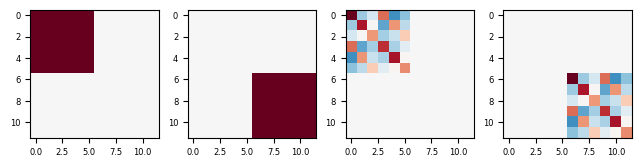

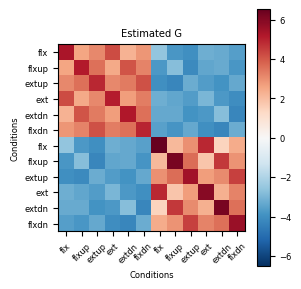

In [5]:
region = 'M1'
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
signal = [5]
nsim = 100
ncond = 12
num_items = 6
rng = np.random.default_rng(seed=3)

file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_mdl = G_mdl / np.trace(G_mdl)
# G_mdl = np.eye(6) / 6
C = G_mdl
within_cov = C.reshape(1,num_items,num_items)
Mtrue = pcm.CorrelationModel('corr', num_items=num_items, corr=1, cond_effect=True, within_cov=within_cov)

# visualize the true G:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1, H, i+1)
    vmin = -np.max(np.abs(Mtrue.Gc[i,:,:]))
    vmax = np.max(np.abs(Mtrue.Gc[i,:,:]))
    plt.imshow(Mtrue.Gc[i,:,:], vmin=vmin, vmax=vmax, cmap='RdBu_r')
    
plt.tight_layout()
plt.show()

cond_vec, part_vec = pcm.sim.make_design(n_cond=12, n_part=10)
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=[0.8,0,0.5,1],
    cond_vec=cond_vec,
    part_vec=part_vec,
    n_sim=nsim,
    n_channel=300,
    signal=signal)

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))
    Dist[i,:,:] = pcm.G_to_dist(G_hat[i,:,:])

# visualize the estimated G:
G_mean = np.mean(G_hat, axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated G')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()





## make models

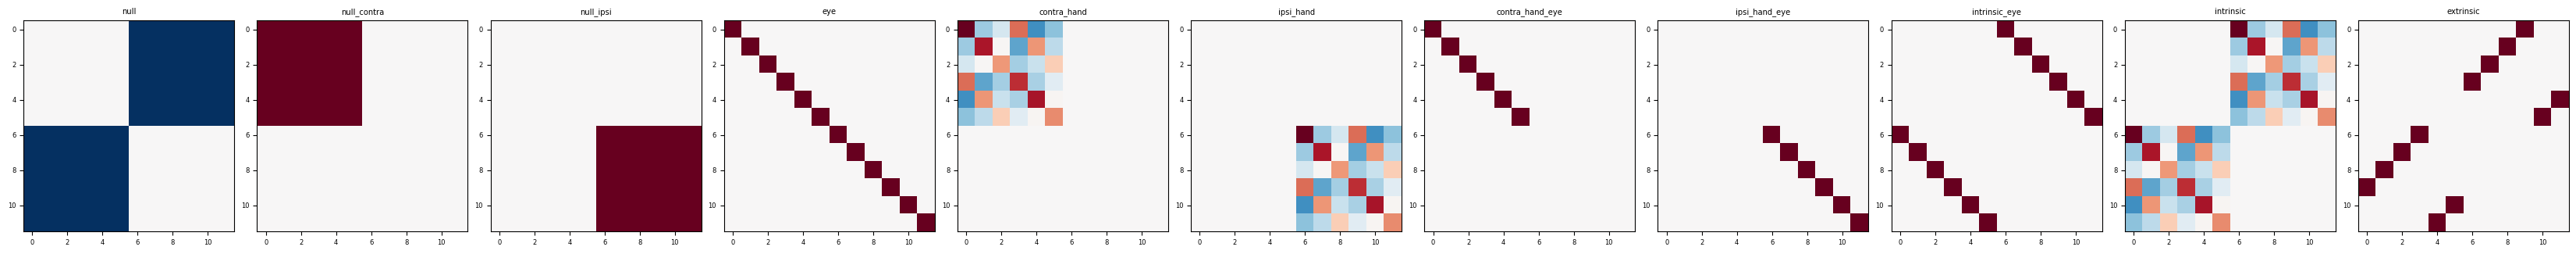

In [6]:
# hand model:
M = []
modelG = {}
ncond = 12

# Null model
# cov = np.zeros((ncond, ncond))
# M.append(pcm.FixedModel('null', cov))

# Simple hand model:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = -1/6
cov[6:12, 0:6] = -1/6
# cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
# cov = cov / np.trace(cov)
modelG['null'] = [cov]
# M.append(pcm.FixedModel('null_contra', cov))

cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = 1
# cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
modelG['null_contra'] = [cov]
# M.append(pcm.FixedModel('null_contra', cov))

cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = 1
# cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
modelG['null_ipsi'] = [cov]
# M.append(pcm.FixedModel('null_ipsi', cov))

# independent:
cov = np.eye(ncond) / ncond
modelG['eye'] = [cov]
# M.append(pcm.FixedModel('eye', cov))

# Best model from unimanual direction encoding:
file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_mdl = G_mdl / np.trace(G_mdl)

G_eye = np.eye(6)

# contra hand structure:
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_mdl
# M.append(pcm.FixedModel('contra hand', cov))
modelG['contra_hand'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_mdl
# M.append(pcm.FixedModel('ipsi hand', cov))
modelG['ipsi_hand'] = [cov]

cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_eye
# M.append(pcm.FixedModel('contra hand', cov))
modelG['contra_hand_eye'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_eye
# M.append(pcm.FixedModel('ipsi hand', cov))
modelG['ipsi_hand_eye'] = [cov]

# intrinsic contra-ipsi relationship:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = np.eye(6)
cov[6:12, 0:6] = np.eye(6)
# cov = cov / np.trace(cov)
modelG['intrinsic_eye'] = [cov]

# intrinsic contra-ipsi relationship:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = G_mdl
cov[6:12, 0:6] = G_mdl
# cov = cov / np.trace(cov)
modelG['intrinsic'] = [cov]

# extrinsic contra-ipsi relationship:
mask_extrinsic = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
mask_extrinsic[0,3] = 1
mask_extrinsic[3,0] = 1
mask_extrinsic[1,2] = 1
mask_extrinsic[2,1] = 1
mask_extrinsic[4,5] = 1
mask_extrinsic[5,4] = 1
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = mask_extrinsic
cov[6:12, 0:6] = mask_extrinsic
# cov = cov / np.trace(cov)
modelG['extrinsic'] = [cov]

# visualize model G matrices:
H = len(modelG)
plt.figure(figsize=(3*H,3))
for i, key in enumerate(modelG.keys()):
    plt.subplot(1, H, i+1)
    vmin = -np.max(np.abs(modelG[key][0]))
    vmax = np.max(np.abs(modelG[key][0]))
    plt.imshow(modelG[key][0], vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.title(key)
plt.tight_layout()
plt.show()

# component models:
M.append(pcm.ComponentModel('data_orthogonal', [modelG['null'][0],modelG['null_contra'][0], modelG['null_ipsi'][0], modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
M.append(pcm.ComponentModel('eye_orthogonal', [modelG['null'][0],modelG['null_contra'][0],modelG['null_ipsi'][0],modelG['contra_hand_eye'][0], modelG['ipsi_hand_eye'][0]]))
M.append(pcm.ComponentModel('intrinsic_eye', [modelG['null'][0],modelG['null_contra'][0],modelG['null_ipsi'][0],modelG['contra_hand_eye'][0], modelG['ipsi_hand_eye'][0], modelG['intrinsic_eye'][0]]))
M.append(pcm.ComponentModel('intrinsic_data', [modelG['null'][0],modelG['null_contra'][0], modelG['null_ipsi'][0], modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0]]))
M.append(pcm.ComponentModel('extrinsic_eye', [modelG['null'][0],modelG['null_contra'][0],modelG['null_ipsi'][0],modelG['contra_hand_eye'][0], modelG['ipsi_hand_eye'][0], modelG['extrinsic'][0]]))





## fit model

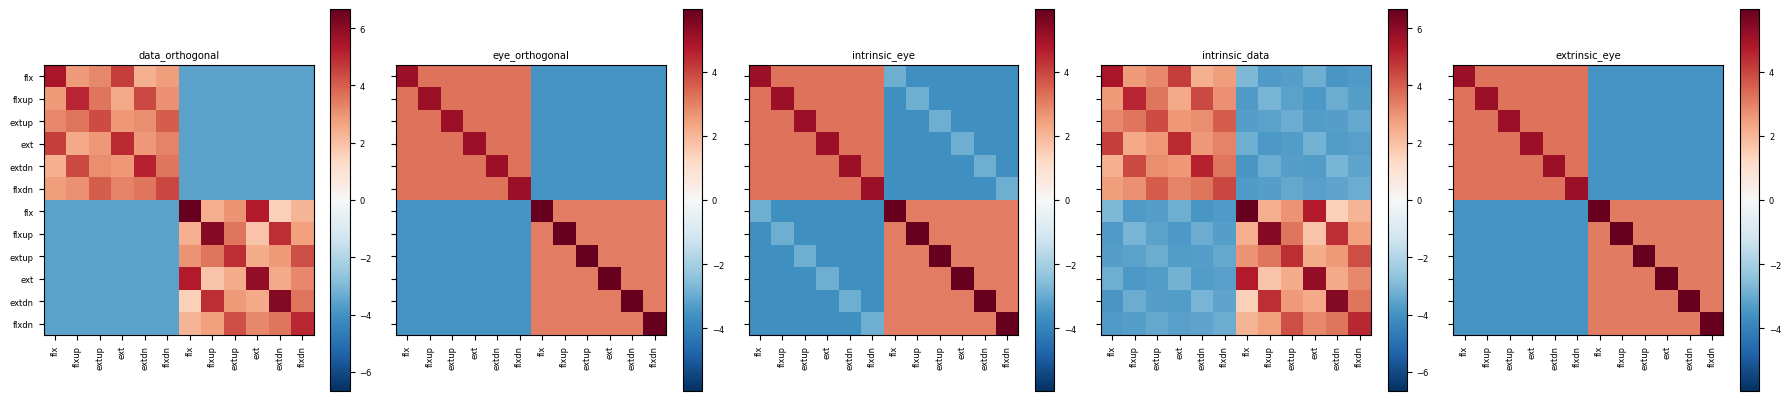

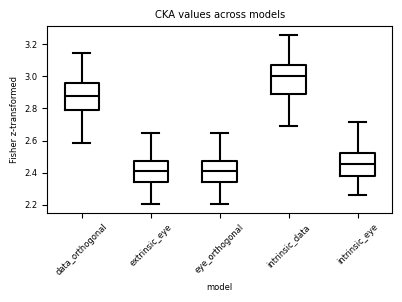

t-test: t=25.510, p=0.000
[3.0592355  3.05668039 3.05533387 2.10538043 2.59733057 0.87837571]


variable             CKA                                              \
model    data_orthogonal eye_orthogonal intrinsic_eye intrinsic_data   
0               0.991369       0.982951      0.984812       0.993001   
1               0.990341       0.978228      0.979626       0.991299   
2               0.994598       0.983738      0.984829       0.995142   
3               0.993071       0.979744      0.981581       0.994241   
4               0.994150       0.981517      0.983158       0.996041   
..                   ...            ...           ...            ...   
95              0.994942       0.986198      0.987208       0.995480   
96              0.994170       0.979446      0.981519       0.995918   
97              0.990178       0.975938      0.978602       0.992502   
98              0.993830       0.985921      0.987158       0.995143   
99              0.993360       0.982533      0.984327       0.995275   

variable                    iterations                               \
model    extrinsic_eye data_orthogonal eye_orthogonal intrinsic_eye   
0             0.982949             2.0            0.0           0.0   
1             0.978225             2.0            0.0           0.0   
2             0.983735             2.0            0.0           0.0   
3             0.979741             2.0            0.0           0.0   
4             0.981516             2.0            0.0           0.0   
..                 ...             ...            ...           ...   
95            0.986196             2.0            0.0           0.0   
96            0.979444             2.0            0.0           0.0   
97            0.975936             2.0            0.0           0.0   
98            0.985920             2.0            0.0           0.0   
99            0.982531             2.0            0.0           0.0   

variable                               
model    intrinsic_data extrinsic_eye  
0                   2.0           8.0  
1                   2.0           8.0  
2                   2.0           9.0  
3                   2.0           8.0  
4                   2.0           6.0  
..                  ...           ...  
95                  2.0           8.0  
96                  3.0           7.0  
97                  5.0           7.0  
98                  2.0           9.0  
99                  2.0           7.0  

[100 rows x 10 columns]

In [7]:
T, theta = fit_CKA_individ(D, M, fixed_effect='block', theta0=None, verbose = False)
# print(theta)

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, nmodels, figsize=(18,4), sharey=True)
for i in range(nmodels):
    th = np.mean(theta[i], axis=1)
    G = M[i].predict(th[:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()

# Convert MultiIndex columns to long form
# Stack the *model* level, so models become rows
T_long = (
    T.stack(level='model')        # move model into the index
      .reset_index()              # index -> columns
      .melt(id_vars=['level_0', 'model'],
            var_name='metric',
            value_name='value')
)
T_long

# boxplot CKA:
T_cka = T_long[T_long['metric'] == 'CKA']
T_cka['value'] = np.arctanh(T_cka['value'])  # Fisher z-transform
plt.figure(figsize=(4,3))
sns.boxplot(data=T_cka, x='model', y='value', color='k', fill=False, width=0.5)
plt.xticks(rotation=45)
plt.title('CKA values across models')
plt.ylabel('Fisher z-transformed')
plt.tight_layout()
plt.show()


# ttest between intrinsic_data vs data_orthogonal:
from scipy.stats import ttest_rel
data_intrinsic = T_cka[T_cka['model'] == 'intrinsic_data']['value'].values
data_orthogonal = T_cka[T_cka['model'] == 'data_orthogonal']['value'].values
t_stat, p_val = ttest_rel(data_intrinsic, data_orthogonal, alternative='greater')
print(f't-test: t={t_stat:.3f}, p={p_val:.3f}')

print(np.mean(theta[3],axis=1))

T



## analytical vs empirical

Empirical Gradient: [-0.02566317 -0.04374099  0.14835411  0.03356119 -0.0077211  -0.07549823
  0.08902583  0.22438228 -0.09588709  0.12900704]
Analytical Gradient: [-0.02566317 -0.04374099  0.14835411  0.03356119 -0.0077211  -0.07549823
  0.08902583  0.22438228 -0.09588709  0.12900704]
Difference: 1.5421277723349408e-10


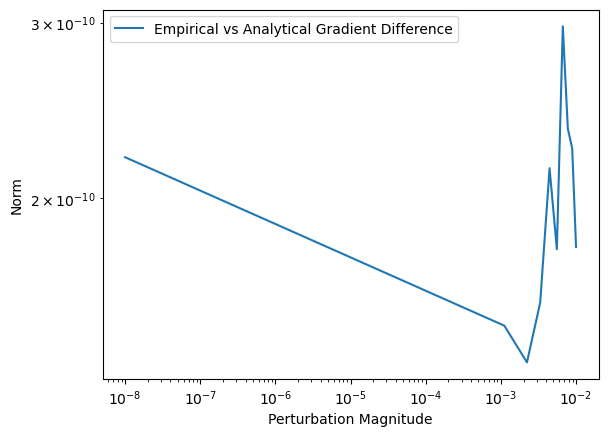

In [7]:
def CKA(a,b):
    cka = (a.T @ b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cka

def grad_empirical(a, b, h=1e-6):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.shape != b.shape:
        raise ValueError("a and b must have the same shape")
    grad = np.zeros_like(b, dtype=float)
    for i in range(b.size):
        ei = np.zeros_like(b)
        ei[i] = 1.0
        sp = CKA(a, b + h*ei)
        sm = CKA(a, b - h*ei)
        grad[i] = (sp - sm) / (2*h)
    return grad

def grad_analytical(a, b, h=1e-6):
    return a/(np.linalg.norm(a) * np.linalg.norm(b)) - (CKA(a,b) * b) / (np.linalg.norm(b)**2)

# compare empirical and analytical gradients:
a = np.random.rand(10)
b = np.random.rand(10)
grad_emp = grad_empirical(a, b)
grad_ana = grad_analytical(a, b)
print("Empirical Gradient:", grad_emp)
print("Analytical Gradient:", grad_ana)
print("Difference:", np.linalg.norm(grad_emp - grad_ana))

# plot both gradients for different differences:
diffs = np.linspace(1e-8, 1e-2, 10)
emp_diffs = []
ana_diffs = []
for d in diffs:
    b_perturbed = b + d * np.random.randn(*b.shape)
    grad_emp = grad_empirical(a, b_perturbed)
    grad_ana = grad_analytical(a, b_perturbed)
    emp_diffs.append(np.linalg.norm(grad_emp - grad_ana))
plt.loglog(diffs, emp_diffs, label='Empirical vs Analytical Gradient Difference')
plt.xlabel('Perturbation Magnitude')
plt.ylabel('Norm')
plt.legend()
plt.show()


